# Dimension reduction with scaling and outliers

Dimensional reduction methods are meant to reduce the feature space to a lower dimension. Usually this is done to visualize high dimnensional data. The visualization is meant to inform on how many clusters there is in the data and/or which features contribute for the separation of clusters. 

<br/>

This project will test different dimensional reduction algorithms when the features are of different scales and when the data contains outliers. The different algorithms are Principal component analysis (PCA), t-distributed Stochastic Neighbor Embedding (t-SNE), kernel principal component analysis (kPCA). These algorithms can be categorized as looking at  *global* (PCA) or *local* (t-SNE and kPCA) behavior.  

<br/>

The project will answer the following questions
- How do the *global* algorithms act different from *local* when it comes to scaling and outliers
- When is scaling necessary
- When do outliers pose a problem

##  Scaling

This section will test out how scaling will affect PCA,kPCA, and t-SNE. More specifically, the experiment will test the impact on the dimensional reduction methods when some of the features have a much larger range than the rest. The data will then be standardized along the features to see if there are any improvements on the visualization

### Experimental set up
- Import necessary libaries
- Generation experimental data
    - **Dataset 1:**
        - all of the features have similiar range
        - The separation of the samples are really only in feature 1
    - **Dataset 2:**
        - Similiar to **dataset 1** except that feature 3 and 4 have a much larger range
      


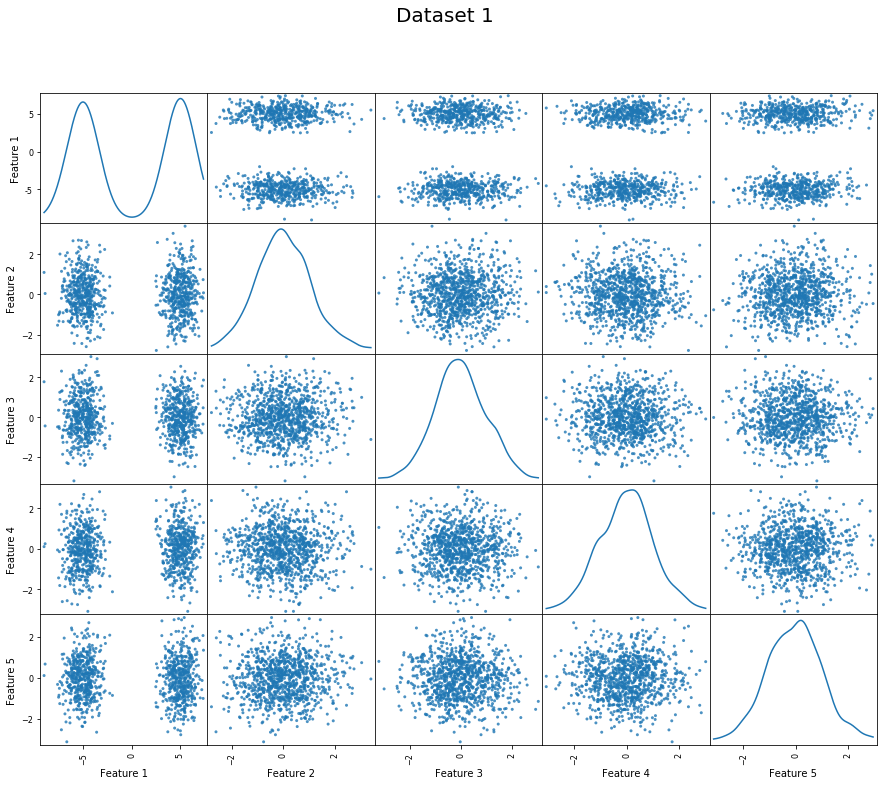

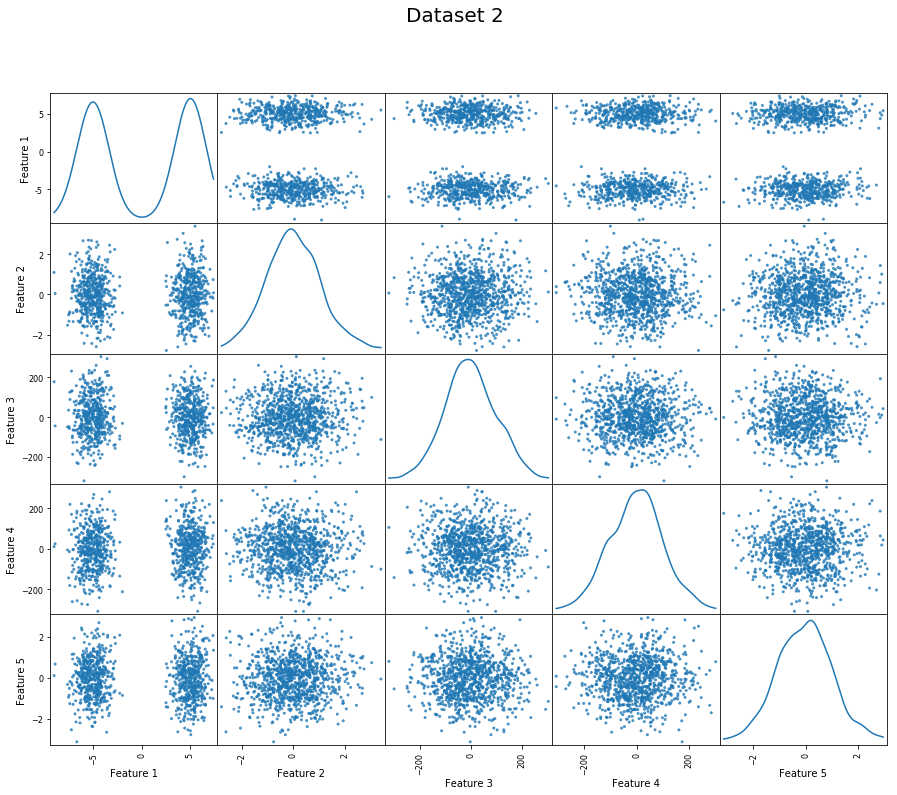

In [1]:
%matplotlib inline

##########   Import necessary libraries   ########### 

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

#Import utils
import sklearn.preprocessing
from sklearn.datasets.samples_generator import make_blobs
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
import pyprind

Random_state = 2019
random.seed(Random_state)
np.random.RandomState(seed=Random_state)




###########  Generate the data and plot it      #########################

X_orig, y = make_blobs(n_samples=1000, centers=[[-5,0,0,0,0],[5,0,0,0,0]],
                  cluster_std= [1,1],n_features=5, random_state=Random_state)

X_upscaled = np.copy(X_orig)

X_upscaled[:,2] = 100*X_orig[:,2]
X_upscaled[:,3] = 100*X_orig[:,3]


#Scatter matrix for original data
df_spm = pd.DataFrame(data=X_orig, columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
scatter_matrix(df_spm, alpha=0.8, figsize=(15, 12), diagonal='kde');
plt.suptitle('Dataset 1',size=20)
plt.show()

#Scatter matrix for upscaled data
df_spm = pd.DataFrame(data=X_upscaled, columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
scatter_matrix(df_spm, alpha=0.8, figsize=(15, 12), diagonal='kde');
plt.suptitle('Dataset 2',size=20)
plt.show()




########  Create objects   for the experimet #########

dimReductions_methods = (
    ('PCA', PCA(n_components=2, svd_solver='full')),
    #('KernelPCA', KernelPCA(n_components=7, kernel='linear')
    ('t-SNE', TSNE(n_components=2, perplexity= 50)),
    ('Kernel-PCA', KernelPCA(n_components=2, kernel='rbf')),
    )


Dataset = (('Dataset 1',X_orig),
           ('Dataset 2',X_upscaled),
          )

simulations = ('Non-scaling','Scaling')





Run the experiment on the two generated datasets. See if scaling affected the algorithms.

Principal components: [[-0.99988558  0.00229955  0.0065312  -0.01283609  0.00401509]
 [-0.01173511 -0.72583634 -0.22611742  0.57387164 -0.30424684]]


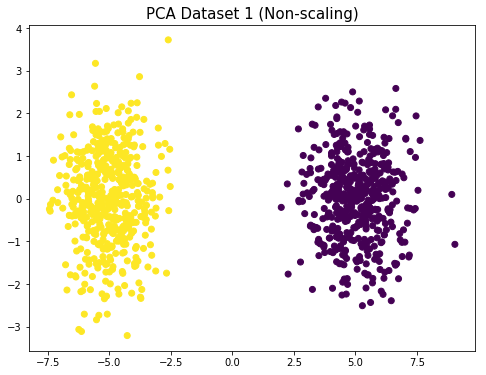

Principal components: [[-3.44124716e-03  3.80607442e-04  2.35591546e-01 -9.71845979e-01
  -1.73298595e-04]
 [ 8.82422411e-04 -1.92044949e-04 -9.71850678e-01 -2.35595906e-01
   1.18083120e-04]]


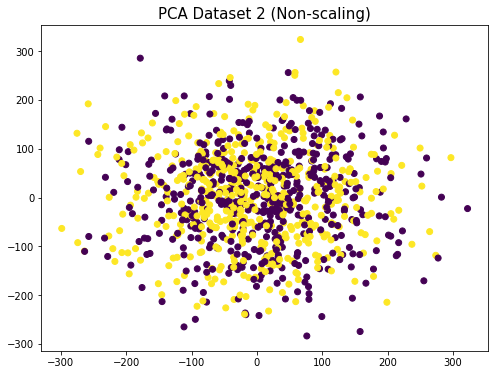

Principal components: [[ 0.56963465 -0.43509482 -0.38712442  0.55677903 -0.16229804]
 [-0.14505891 -0.47767723  0.25745497 -0.27347634 -0.7808393 ]]


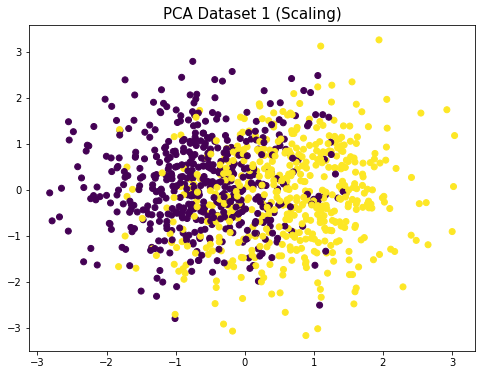

Principal components: [[ 0.56963465 -0.43509482 -0.38712442  0.55677903 -0.16229804]
 [-0.14505891 -0.47767723  0.25745497 -0.27347634 -0.7808393 ]]


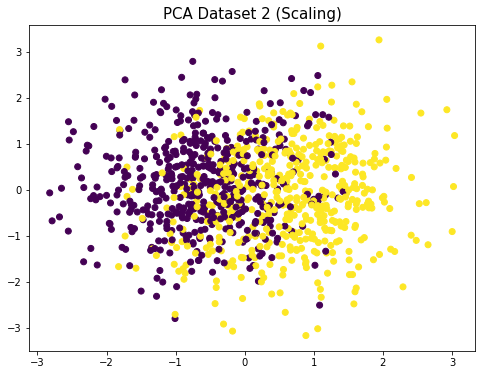

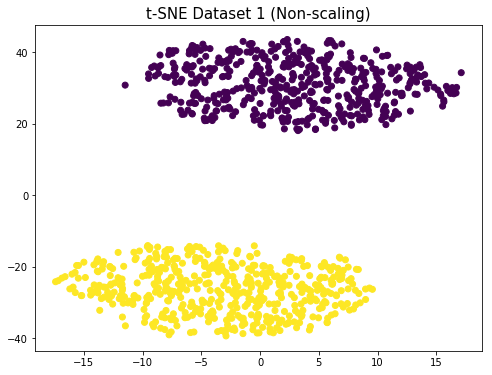

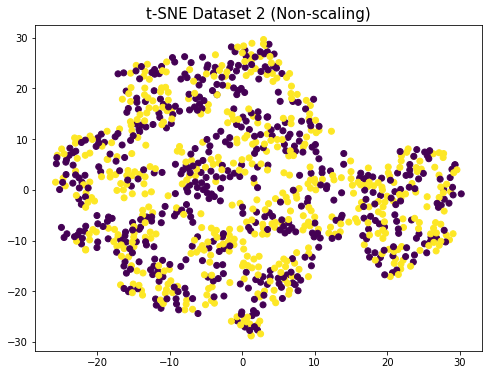

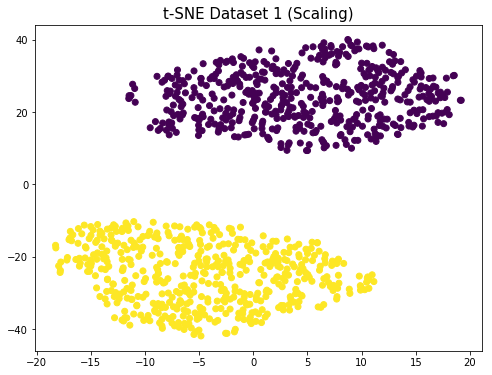

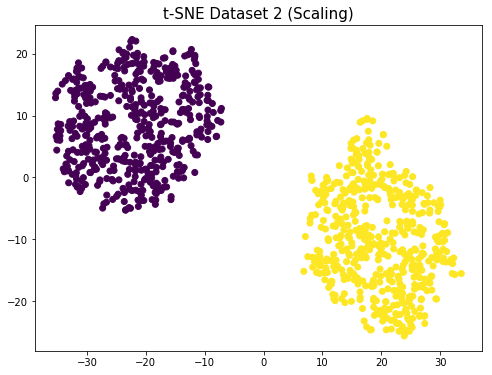

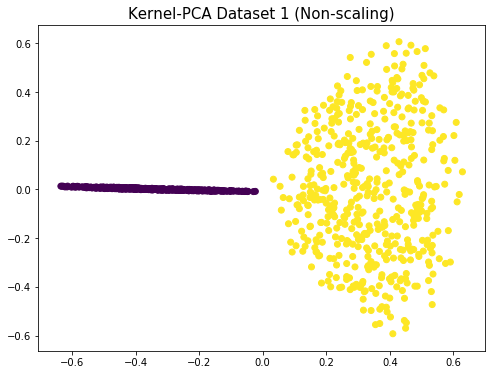

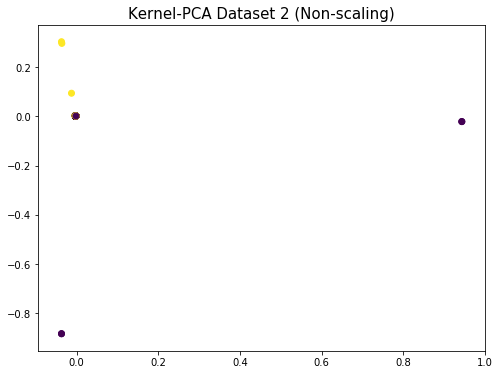

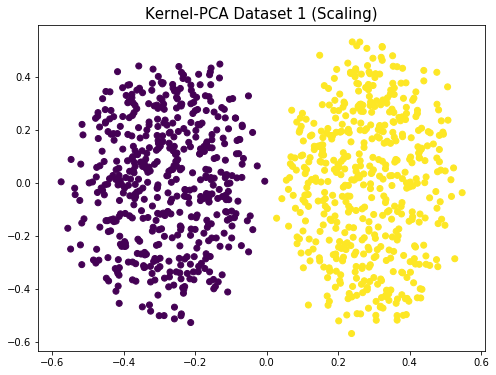

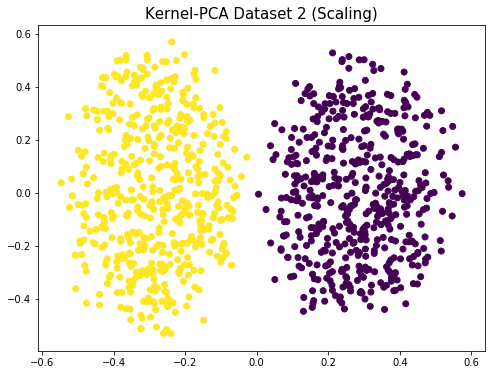

In [2]:
for name,dim_red_method in dimReductions_methods:
    for simulation in simulations:
        for datasetName,dataset in Dataset:
            X = np.copy(dataset)
    
            if(simulation=='Scaling'):
                X = StandardScaler().fit_transform(X)
                #X = robust_scale(X, axis=1, with_centering=True, with_scaling=True, quantile_range=(10, 90))
    
            X_dim_red = dim_red_method.fit_transform(X)
            if(name=='PCA'):
                print('Principal components: {0}'.format(dim_red_method.components_))
            plt.figure(figsize=(8,6))
            plt.title(name  + ' ' + datasetName + ' (' + simulation + ')',size=15)
            plt.scatter(X_dim_red[:,0],X_dim_red[:,1], c = y)
            plt.show()
            


### Conclusions

- All algorithms performed better on **dataset 2** when the features were standardized. This is because feature 3 and 4 (irrelevant features) contributes significantly less to the transformation once standardization is applied
- PCA worsened when the features were standardized in **dataset 1**. This is because the standardiziation makes each features contribute more to the principal components. Ideally, the first principal component should only be made from feature 1 
- Data needs to be scaled before using kPCA. Otherwise new space implicitly produced by the kernel function is of no use

## Outliers

This section will investigate the effects on the dimensional reductions methods when the dataset contains outliers.

### Experimental set up
- Data
    - **Outlier type 1:** Same as dataset 1 in the scaling experiment, but where 10 % of the data are scaled up X10 **in all features**
    - **Outlie type 2:** Same as dataset 1 in the scaling experiment, but where 10 % of the data are scaled up X10 in **feature 3 and 4**
- Try if *Robust scaling* can improve the results. *Robust scaling* will scale the samples according to a Interquartile range (typically 1st and 3rd quantile)

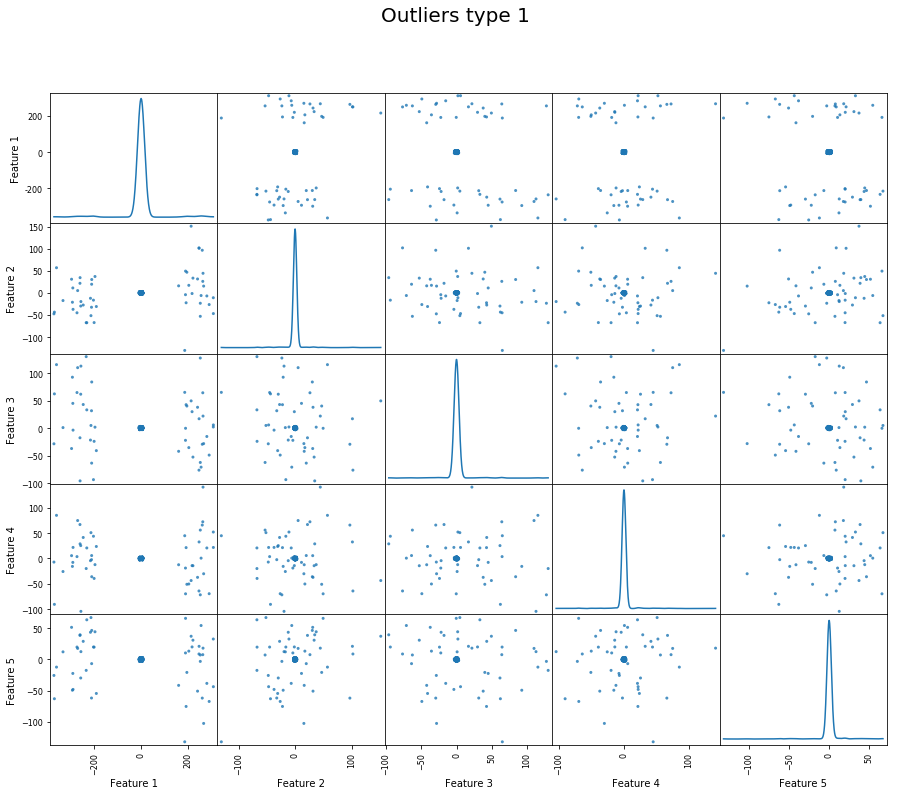

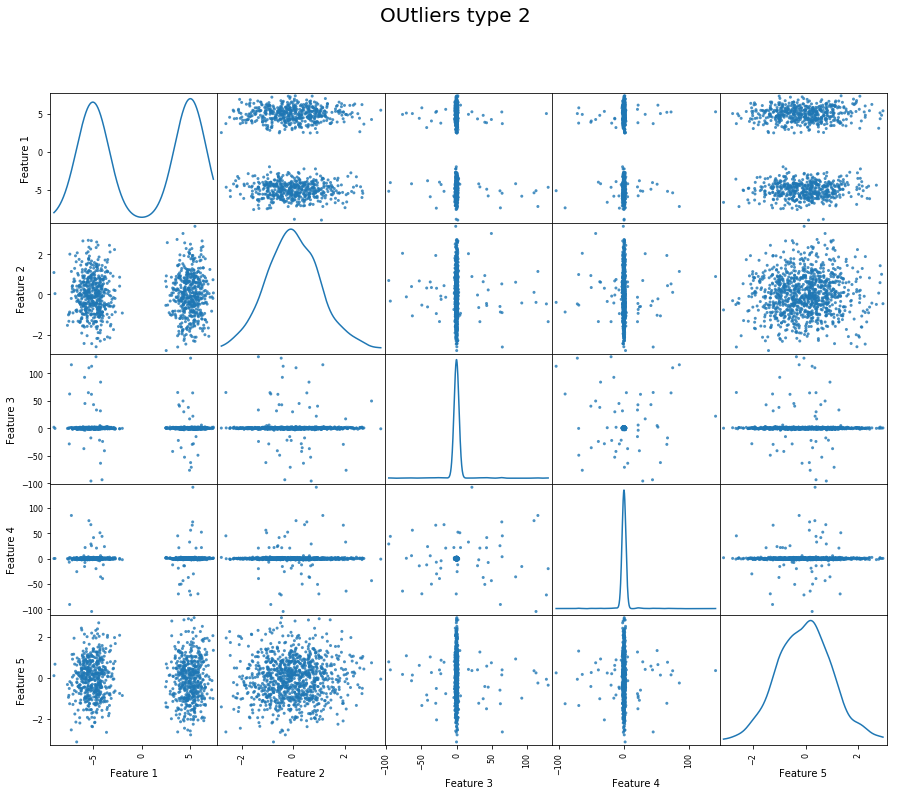

In [3]:
X_orig, y = make_blobs(n_samples=[500,500], centers=[[-5,0,0,0,0],[5,0,0,0,0]],
                  cluster_std= [1,1],n_features=5, random_state=Random_state)

#Create first type of outlier data
X_outliers_spread_across_every_feature = np.copy(X_orig)
X_outliers_spread_across_every_feature[:50] = 50*X_orig[:50]


#Create second type of outlier data
X_outliers_across_two_irreleant_features = np.copy(X_orig)
X_outliers_across_two_irreleant_features[:50,2] = 50*X_orig[:50,2]
X_outliers_across_two_irreleant_features[:50,3] = 50*X_orig[:50,3]


df_spm = pd.DataFrame(data=X_outliers_spread_across_every_feature, 
                      columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
scatter_matrix(df_spm, alpha=0.8, figsize=(15, 12), diagonal='kde');

plt.suptitle('Outliers type 1',size=20)
plt.show()

df_spm = pd.DataFrame(data=X_outliers_across_two_irreleant_features, 
                      columns=['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5'])
scatter_matrix(df_spm, alpha=0.8, figsize=(15, 12), diagonal='kde');

plt.suptitle('OUtliers type 2',size=20)
plt.show()


dimReductions_methods = (
    ('PCA', PCA(n_components=2, svd_solver='full')),
    #('KernelPCA', KernelPCA(n_components=7, kernel='linear')
    ('t-SNE', TSNE(n_components=2, perplexity= 50)),
    ('Kernel-PCA', KernelPCA(n_components=2, kernel='rbf')),
    )

simulations = ['Non-scaling','Robust scaling (for outliers)']

datasets = (('Outerliers type 1',X_outliers_spread_across_every_feature),
            ('Outliers type 2',X_outliers_across_two_irreleant_features),
           )





### Experiment

Principal components: [[-0.99633849 -0.05947793  0.05464111  0.0056857   0.02745943]
 [ 0.05431373 -0.35132028  0.82864997 -0.13124599 -0.41199247]]


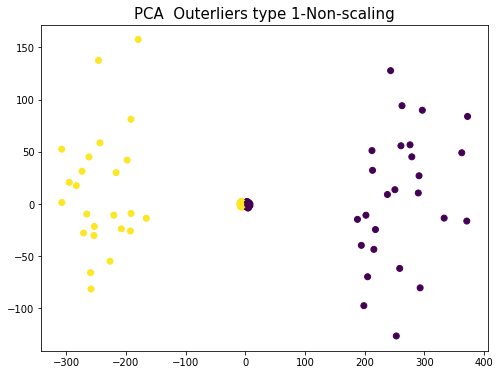

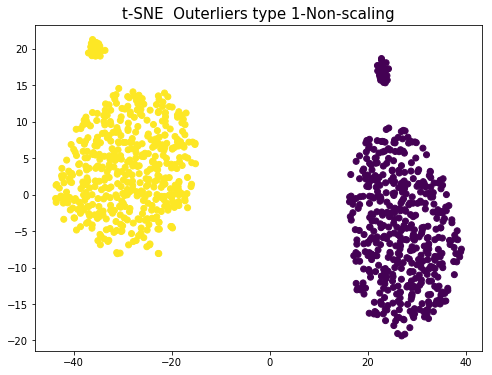

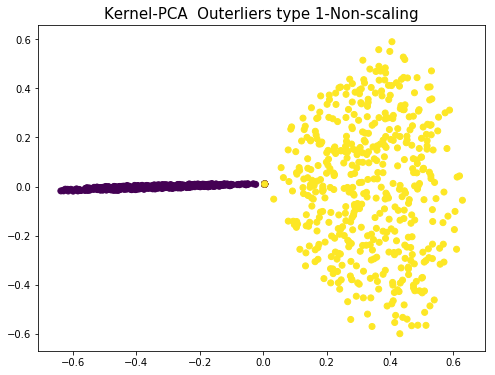

Principal components: [[-2.32468575e-02 -2.15595157e-03  9.92363995e-01 -1.21094543e-01
  -2.17908674e-03]
 [-4.98076447e-03 -1.09513100e-03  1.21010675e-01  9.92637774e-01
   8.11148688e-04]]


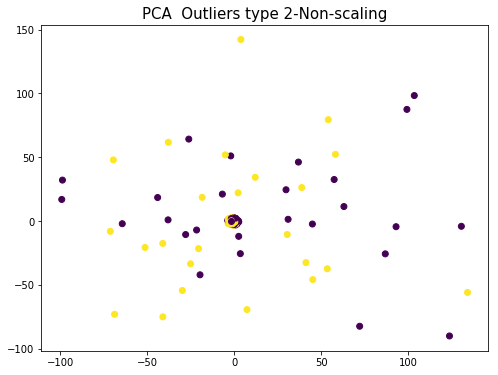

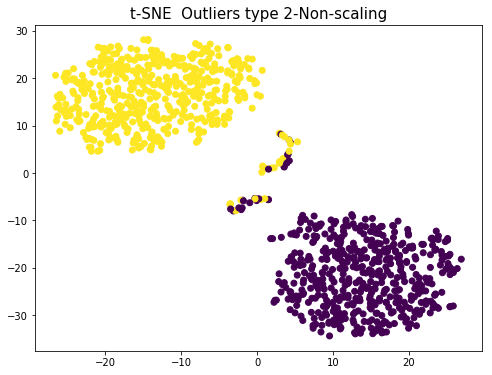

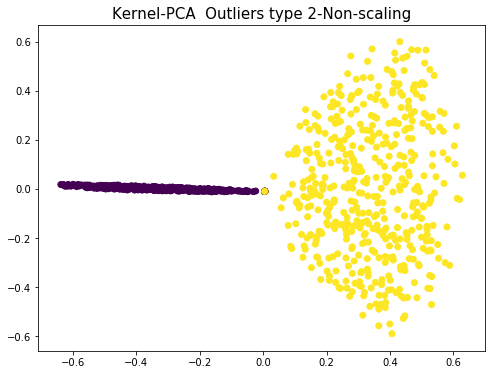

Principal components: [[-0.99442684  0.052107    0.0572052   0.04087047  0.05879875]
 [-0.00940926 -0.5777706  -0.14348574  0.80086431 -0.06419347]]


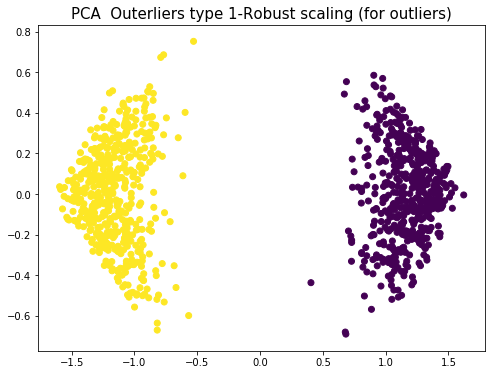

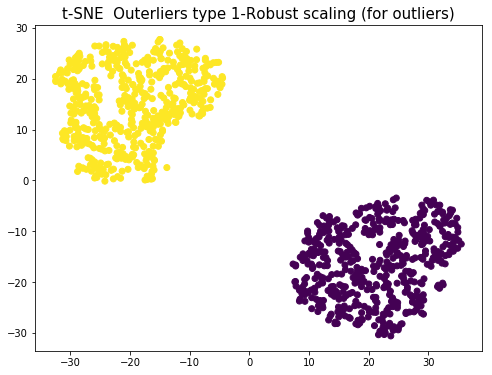

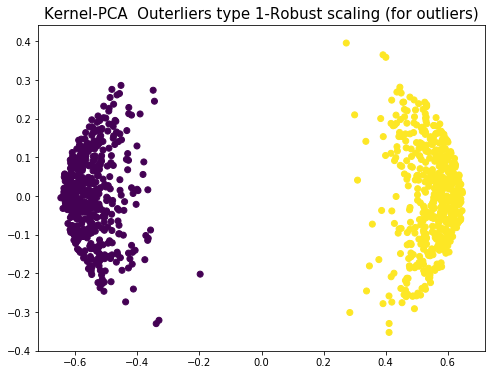

Principal components: [[-0.99418198  0.05563036  0.05923821  0.04110889  0.05751831]
 [-0.03059288  0.04695181 -0.92077785  0.37017128  0.10954894]]


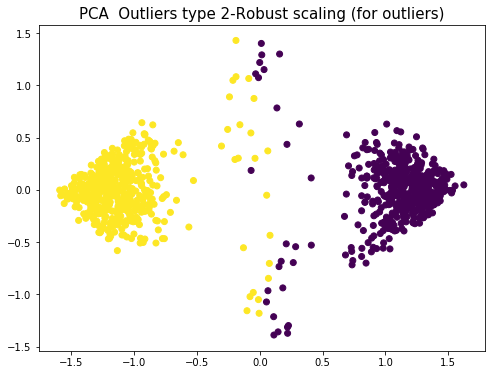

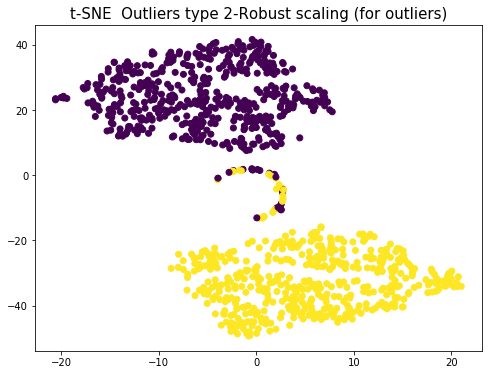

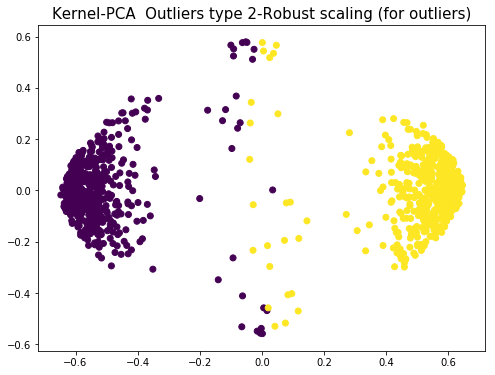

In [4]:
for simulation in simulations:
    for outlierType,dataset in datasets:
        for name,dim_red_method in dimReductions_methods:
    
            X = np.copy(dataset)
            if(simulation=='Robust scaling (for outliers)'):
                #X = StandardScaler().fit_transform(X)
                #X = RobustScaler(with_centering=True, with_scaling=True,quantile_range=(10, 90)).fit_transform(X)
                X = robust_scale(X, axis=1, with_centering=True, with_scaling=True, quantile_range=(10, 90))
            
            X_dim_red = dim_red_method.fit_transform(X)
        
            if(name=='PCA'):
                print('Principal components: {0}'.format(dim_red_method.components_))
            if(name=='Kernel-PCA' and simulation=='Non-scaling'):
                X = StandardScaler().fit_transform(X)
    
            #Plotting
            plt.figure(figsize=(8,6))
            plt.title(name + ' ' + ' ' + outlierType + '-' +simulation ,size=15)
            plt.scatter(X_dim_red[:,0],X_dim_red[:,1], c = y)
        
            #Potentially zoom in to see more clearly
            #if(name=='PCA' and simulation=='Non-scaling'):
            #    plt.ylim((-5, 5)) 
            #    plt.xlim((-5, 5))
            #    print('yo')
            
            plt.show()


### Conclusions

- Outliers only posed a problem when they deviate enough only within irrelevant features (type 2)
    - t-SNE could handle this type with the exception of clumping all of the outliers together in the middle. In the type 1 scenario, the outliers would form mini clusters beside the big cluster
- If the outliers deviate in all features then all algorithms will still separate the clusters
- All algorithms improved when using robust scaling

## Additional code 

The following code section will help try further understand PCA behavior with scaling and the addition of outliers 

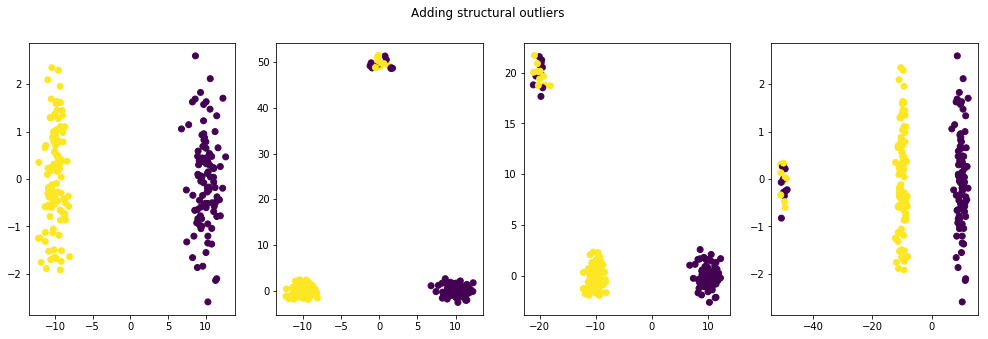

In [5]:
#Create and visualize original data

X, y = make_blobs(n_samples=[100,100], centers=[[10,0],[-10,0]],
                  cluster_std= [1,1],n_features=2, random_state=Random_state)
    


### Add outliers ###
X_ortogonal_outliers = np.copy(X)
X_diagonal_outliers = np.copy(X)
X_AlongPCA_outliers = np.copy(X)

for i in range(int(len(X)*0.1)):
    X_ortogonal_outliers[i] = [np.random.normal(0, 1, 1),np.random.normal(50, 1, 1)]
    X_diagonal_outliers[i] = [np.random.normal(-20, 1, 1),np.random.normal(20, 1, 1)]
    X_AlongPCA_outliers[i] = [np.random.normal(-50, 1, 1),np.random.normal(0, 0.3, 1)]


    
####  Plottting  #####
plt.figure(1, figsize=(17, 5))
plt.suptitle('Adding structural outliers')

#Original data
plt.subplot(141) #Original data
plt.scatter(X[:, 0], X[:, 1], c=y)

plt.subplot(142)
plt.scatter(X_ortogonal_outliers[:, 0], X_ortogonal_outliers[:, 1], c=y)


### Plot Digonal outliers ###
plt.subplot(143)
plt.scatter(X_diagonal_outliers[:, 0], X_diagonal_outliers[:, 1], c=y)

####  Plot along PCA outliers  ####
plt.subplot(144)
plt.scatter(X_AlongPCA_outliers[:, 0], X_AlongPCA_outliers[:, 1], c=y)
plt.show()    



    



### Visualize the principal components

When adding structual outliers in a certain direction, it can be seen that the first principal components (red arrows) will be selected in the direction of the outliers. 

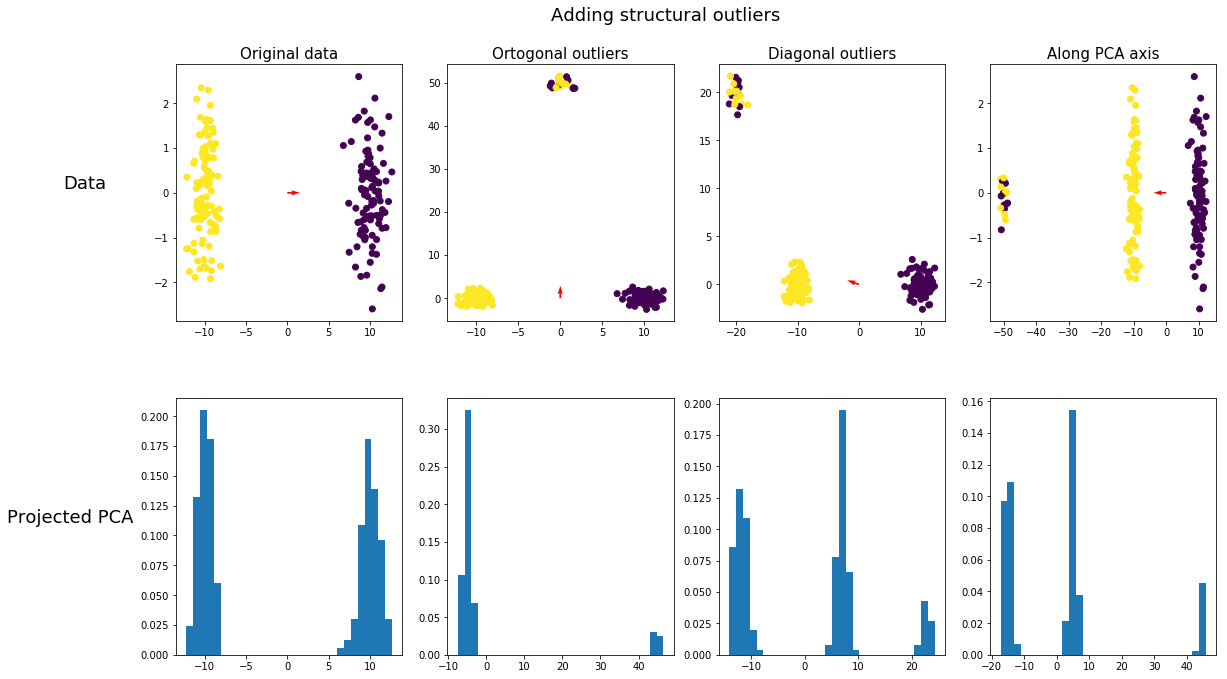

In [6]:
dimReductions_methods = (
    ('Data', PCA(n_components=1, svd_solver='full')),
    ('Projected PCA', PCA(n_components=1, svd_solver='full'))
    #('KernelPCA', KernelPCA(n_components=7, kernel='linear')
    #('LDA',LinearDiscriminantAnalysis()))
    )

TypesOfOutliers = (
    ('Original data',X),
    ('Ortogonal outliers',X_ortogonal_outliers),
    ('Diagonal outliers',X_diagonal_outliers),
    ('Along PCA axis',X_AlongPCA_outliers),
)

plt.figure(1, figsize=(17, 10))
plt.subplots_adjust(top=0.90, bottom=0.08, left=0.10, right=0.95, hspace=0.30, wspace=0.20)
plt.suptitle('Adding structural outliers', size=18)
plot_num = 1



for name, method in dimReductions_methods:   #Loop through each clustering algorithms
    for typeOfOutlier,data in TypesOfOutliers:
        #print(data[:10])
        ProjectedData = method.fit_transform(data) 
        
        #plot the principal components
        if(name=='Data'):
            plt.subplot(len(dimReductions_methods),len(TypesOfOutliers), plot_num) 
            plt.title(typeOfOutlier, size=15)   
            plt.scatter(data[:, 0], data[:, 1], c=y)
            origin = [0], [0]
            plt.quiver(*origin, method.components_[:,0], method.components_[:,1], color=['r','b','g'])
        
        ## plot density##
        elif(name == 'Projected PCA'):
            plt.subplot(len(dimReductions_methods),len(TypesOfOutliers), plot_num)    
            count, bins, ignored = plt.hist(ProjectedData, 30, density=True)
            
        #if plot_num % len(dimReductions_methods) == 0:
        #        
        
        if (plot_num % len(TypesOfOutliers)-1 == 0): 
                plt.ylabel(name,rotation=0, size=18, labelpad = 70)
        plot_num += 1

plt.show()
    



## Scaling
Plot how much each principal component contribures with variance with and without scaling. The red arrow is the first principal components. The blue arrow is the second principal component.

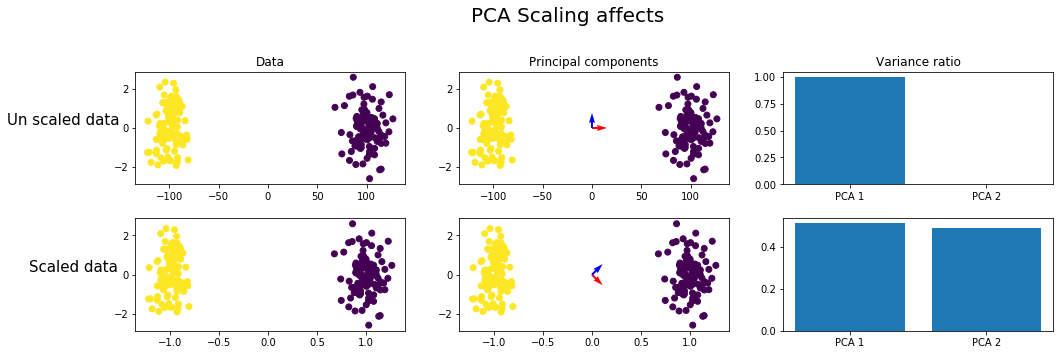

[[ 9.99999976e-01 -2.17704318e-04]
 [ 2.17704318e-04  9.99999976e-01]]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[-4.66293670e-17 -5.55111512e-19]
[1. 1.]


In [7]:
from sklearn.preprocessing import StandardScaler, scale, normalize


dimReductions_methods = (
    
    ('PCA', PCA()),
    #('KernelPCA', KernelPCA(n_components=7, kernel='linear')
    #('LDA',LinearDiscriminantAnalysis()))
    )

X, y = make_blobs(n_samples=200, centers=[[10,0],[-10,0]],
                  cluster_std= [1,1],n_features=2, random_state=Random_state)



#Scaling some of the features
X_Unscaled = np.copy(X)
X_Unscaled[:,0] = 10*X[:,0]

scale = StandardScaler(copy=True)
X_scaled = scale.fit_transform(X_Unscaled)


'''
for name, method in dimReductions_methods:   #Loop through each clustering algorithms
    X_dimReduce = method.fit_transform(X) 
    
    print(method.components_)
    print(method.explained_variance_ratio_)
'''


pca = PCA()
pca_scaled = PCA()
pca.fit(X_Unscaled)
pca_scaled.fit(X_scaled)



#Plot the data
plt.figure(1, figsize=(15, 5))
plt.subplots_adjust(top=0.80, bottom=0.08, left=0.10, right=0.95, hspace=0.30, wspace=0.20)

plt.suptitle('PCA Scaling affects',size = 20)
plt.subplot(231)
plt.title('Data')
plt.ylabel('Un scaled data',size = 15, rotation='horizontal', labelpad = 50)
plt.scatter(X_Unscaled[:, 0], X_Unscaled[:, 1], c=y)
plt.subplot(232)
plt.title('Principal components')
plt.scatter(X_Unscaled[:, 0], X_Unscaled[:, 1], c=y)
origin = [0], [0]
plt.quiver(*origin, pca.components_[:,0], pca.components_[:,1], color=['r','b','g'])
plt.subplot(233)
plt.title('Variance ratio')
plt.bar(['PCA 1','PCA 2'], pca.explained_variance_ratio_)


#Second row in the subplots
plt.subplot(234)
plt.ylabel('Scaled data',size = 15, rotation='horizontal', labelpad = 40)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y)

plt.subplot(235)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y)
origin = [0], [0]
plt.quiver(*origin, pca_scaled.components_[:,0], pca_scaled.components_[:,1], color=['r','b','g'])

plt.subplot(236)
plt.bar(['PCA 1','PCA 2'], pca_scaled.explained_variance_ratio_)

plt.show()

print(pca.components_)
print(pca_scaled.components_)
print(np.mean(X_scaled, axis=0))
print(np.std(X_scaled, axis=0))


